# Телеком



Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

**Цель**

Разработать и реализовать модель машинного обучения, способную прогнозировать отток клиентов оператора связи "Ниединогоразрыва.ком" на основе имеющихся персональных данных о клиентах, информации о тарифах и договорах. Это позволит оператору предложить персонализированные промокоды и специальные условия, чтобы увеличить вероятность сохранения клиентов и снизить отток.
**AUC-ROC >= 0.85**.

**Задачи**

Подготовка данных: 
   - Импорт и загрузка данных о клиентах, их тарифах и договорах.
   - Получение информации о размере данных
   - Объединение таблиц.
   - Приведение имён столбцов к PEP8, если требуется.
   - Проверка и очистка данных от пропущенных значений.
   - Проверка и удаление дубликатов.
   - Преобразование переменных к необходимым типам данных, если требуется. 

Подготовка признаков:
   - Добавление новых признаков
   - Определение целевого признака.
   - Преобразование целевой переменной в числовой формат, если требуется.
   - Проверка дисбаланса класса и преобразование в случае необходимости.
   - Выбор значимых признаков для модели и удаление при необходимости лишних.
   - Разделение данных: обучающую и тестовую.
   - Преобразование категориальных признаков в числовые, если требуется.
   - Масштабирование числовых признаков, если требуется.
 

Обучение модели:
   - Выбор 2 и более алгоритмов машинного обучения для задачи прогнозирования оттока.
   - Подбор гиперпараметров.
   - Обучение моделей.

Оценка и выбор модели:
   - Оценка качества модели с использованием метрики AUC-ROC.
   - Сравнение различных моделей и выбор наиболее подходящей модели для задачи.
   - Построение и анализ матрицы ошибок.
   - Интерпретация важности признаков для прогнозирования оттока.
   - Выявление основных факторов, влияющих на отток клиентов.
   
Отчёт

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [3]:
RANDOM_STATE = 190623

## Подготовка данных

### Импорт и загрузка данных

Загрузим все необходимые данные

In [4]:
contract = pd.read_csv('contract_new.csv')

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
internet = pd.read_csv('internet_new.csv')

In [7]:
internet.head(20)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [8]:
phone = pd.read_csv('phone_new.csv')

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
personal = pd.read_csv('personal_new.csv')

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


### Размер данных

Узнаем размер наших данных

In [12]:
contract.shape

(7043, 8)

In [13]:
internet.shape

(5517, 8)

In [14]:
phone.shape

(6361, 2)

In [15]:
personal.shape

(7043, 5)

**Вывод**
- contract: Объектов **7043**, признаков **8**
- internet: Объектов **5517**, признаков **8**
- phone: Объектов **6361**, признаков **2**
- personal: : Объектов **7043**, признаков **5**

### Объединение таблиц

У нас 4 таблицы, объеденим их по ключу `customerID`. Будем использовать левое внешнее соединение таблиц. Первой таблицой будет `personal`.

In [16]:
merged_data = personal.merge(phone, on='customerID', how='left')\
                      .merge(internet, on='customerID', how='left')\
                      .merge(contract, on='customerID', how='left')

In [17]:
merged_data.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [18]:
merged_data.shape

(7043, 20)

In [19]:
merged_data['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [20]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Вывод**

- Успешно объединили таблицы
- Размер нового датасета: Объектов **7043**, признаков **20**

### Приведение имён столбцов к PEP8

In [21]:
columns_snake_case = []
for column in merged_data.columns:
    columns_snake_case.append(re.sub('(?!^)([A-Z]+)', r'_\1',column).lower())

merged_data.columns = columns_snake_case

In [22]:
merged_data.head(50)

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


### Изменение типа

In [23]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   multiple_lines     6361 non-null   object 
 6   internet_service   5517 non-null   object 
 7   online_security    5517 non-null   object 
 8   online_backup      5517 non-null   object 
 9   device_protection  5517 non-null   object 
 10  tech_support       5517 non-null   object 
 11  streaming_tv       5517 non-null   object 
 12  streaming_movies   5517 non-null   object 
 13  begin_date         7043 non-null   object 
 14  end_date           7043 non-null   object 
 15  type               7043 non-null   object 
 16  paperless_billing  7043 

Признак `total_charges` является объектом, нужно поменять его тип на `float`, так как значения в нём дробные числа. Признак `senior_citizen` имеет числовой тип, однако там только 2 значения: 1 и 0, переведем тип в object.

In [24]:
merged_data['total_charges'] = pd.to_numeric(merged_data['total_charges'], errors='coerce')
merged_data['senior_citizen'] = merged_data['senior_citizen'].astype('str')

In [25]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   multiple_lines     6361 non-null   object 
 6   internet_service   5517 non-null   object 
 7   online_security    5517 non-null   object 
 8   online_backup      5517 non-null   object 
 9   device_protection  5517 non-null   object 
 10  tech_support       5517 non-null   object 
 11  streaming_tv       5517 non-null   object 
 12  streaming_movies   5517 non-null   object 
 13  begin_date         7043 non-null   object 
 14  end_date           7043 non-null   object 
 15  type               7043 non-null   object 
 16  paperless_billing  7043 

**Вывод**

- Поменяли тип данных `total_charges` с object на float
- Поменяли тип данных `senior_citizen` с float на object

### Пропущенные значения

Рассмотрим пропущенные значения

In [26]:
pd.DataFrame(round(merged_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
customer_id,0.000000
gender,0.000000
senior_citizen,0.000000
partner,0.000000
dependents,0.000000
multiple_lines,9.700000
internet_service,21.700000
online_security,21.700000
online_backup,21.700000
device_protection,21.700000


Есть пропуски в 8 признаках:
- multiple_lines - тип object 
- internet_service - тип object 
- online_security - тип object
- online_backup - тип object	
- device_protection	- тип object
- tech_support - тип object
- streaming_tv - тип object
- streaming_movies - тип object
- total_charges - тип float

In [27]:
categorical_columns = ['internet_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

Предположим, что если пропущенно значение в признаках `multiple_lines`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, то значит услуга не подключина, заполним значением `No`.

In [28]:
merged_data[categorical_columns] = merged_data[categorical_columns].fillna('No')

In [29]:
merged_data[merged_data['total_charges'].isnull()]

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,Female,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,Male,0,No,Yes,No,No,No,No,No,No,No,No,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Количество пропусков очень мало, мы можем их заполнить 0.

In [30]:
merged_data['total_charges'] = merged_data['total_charges'].fillna(0)

In [31]:
pd.DataFrame(round(merged_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
customer_id,0.000000
gender,0.000000
senior_citizen,0.000000
partner,0.000000
dependents,0.000000
multiple_lines,0.000000
internet_service,0.000000
online_security,0.000000
online_backup,0.000000
device_protection,0.000000


**Вывод**

Пропуски были успешно заполнены в столбцах.
- multiple_lines -  пропуски заполнены значением `No`
- internet_service - пропуски заполнены модой
- online_security - пропуски заполнены значением `No`
- online_backup - пропуски заполнены значением `No`	
- device_protection	- пропуски заполнены значением `No`
- tech_support - пропуски заполнены значением `No`
- streaming_tv - пропуски заполнены значением `No`
- streaming_movies - пропуски заполнены значением `No`
- merged_data - было 11 пропусков, заменены на ноль

### Анализ распределения признаков

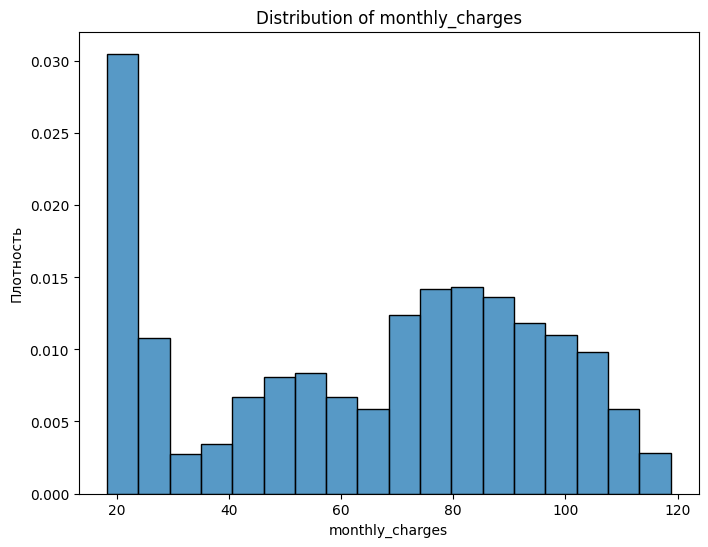

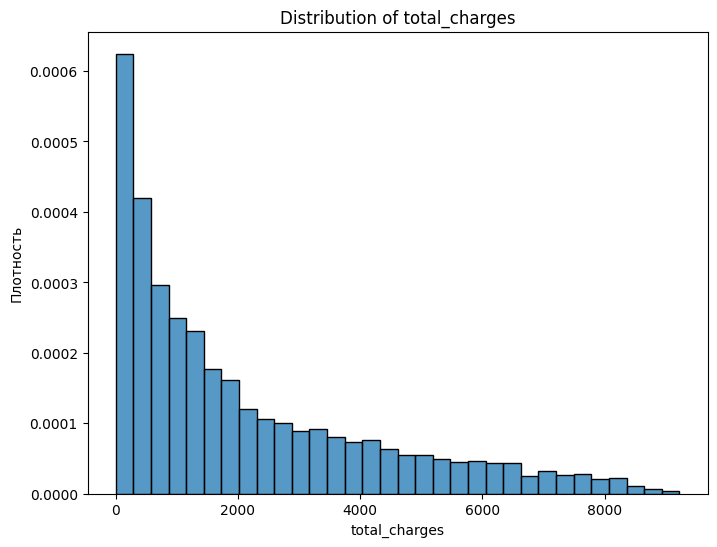

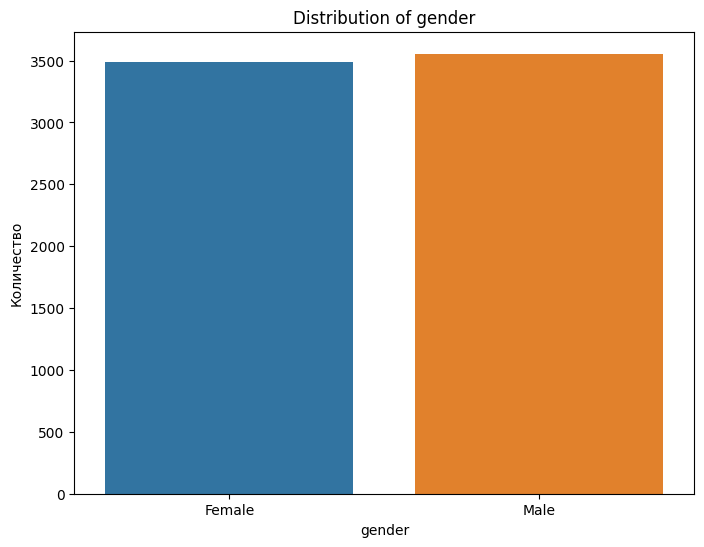

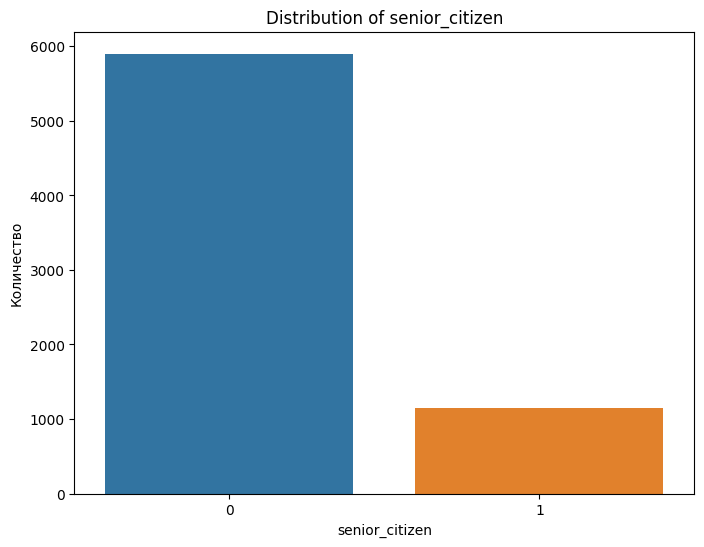

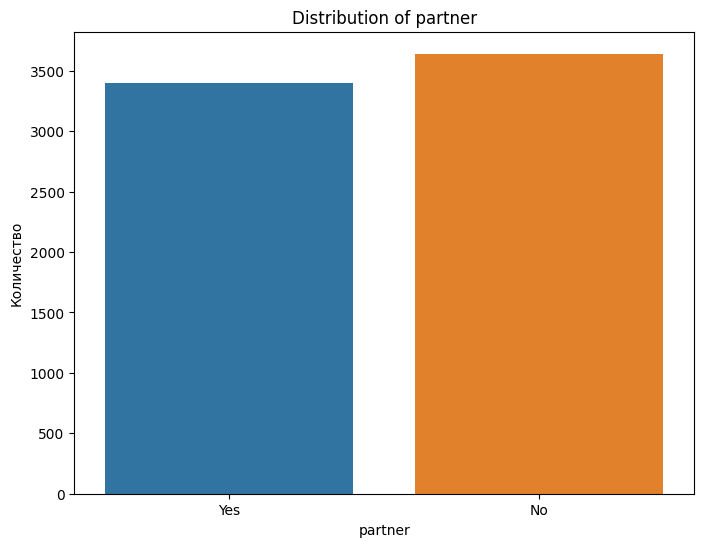

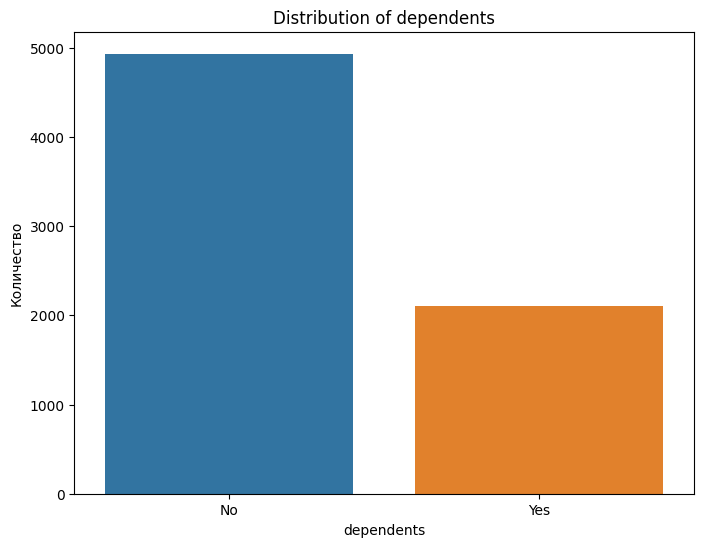

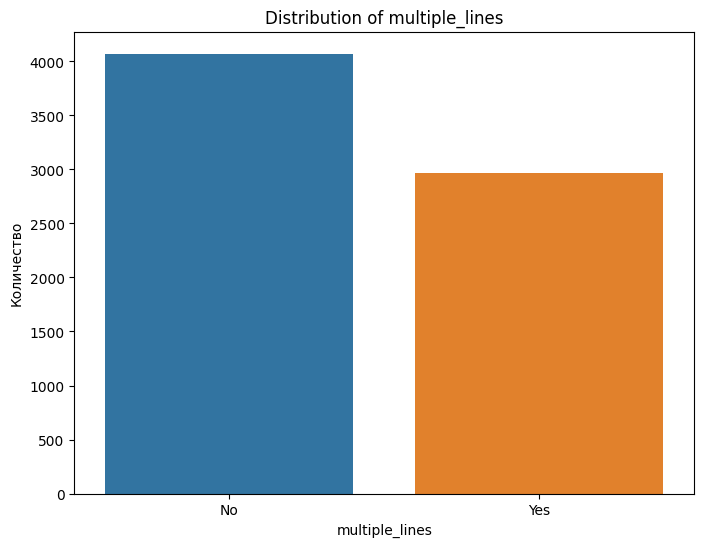

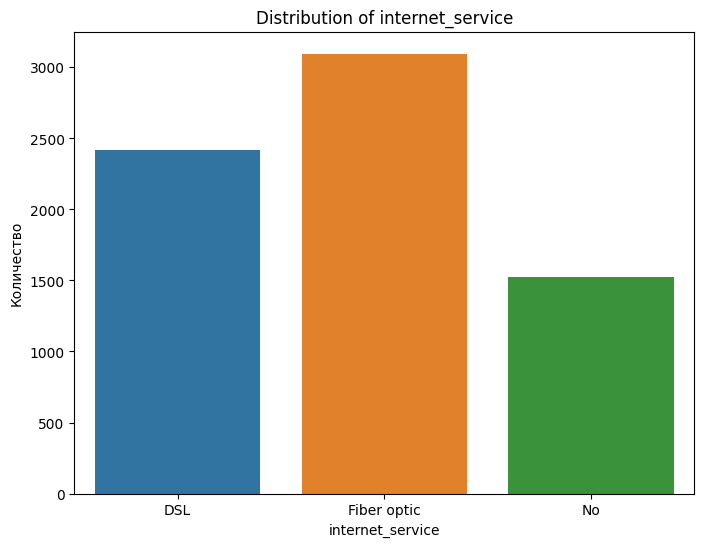

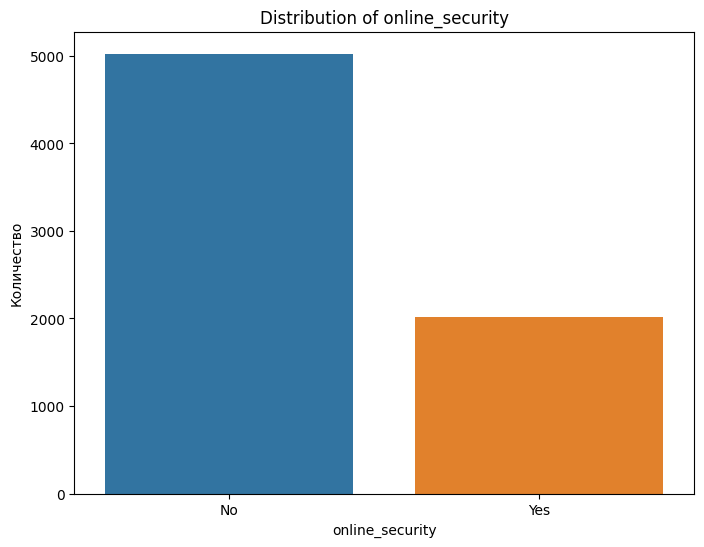

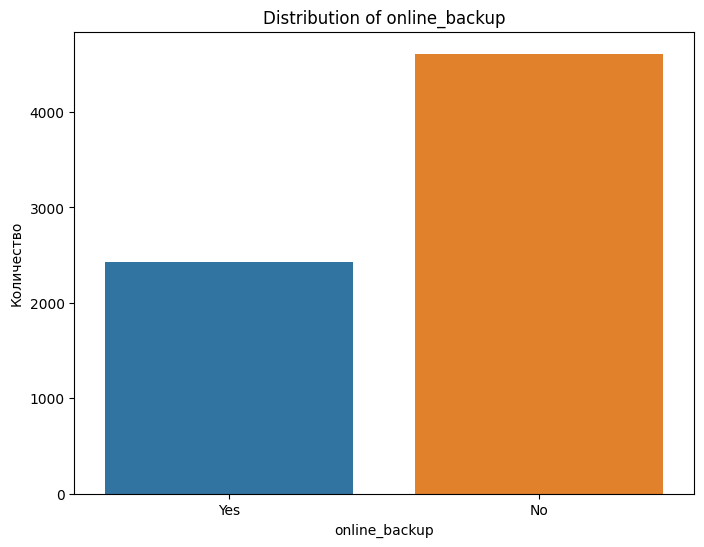

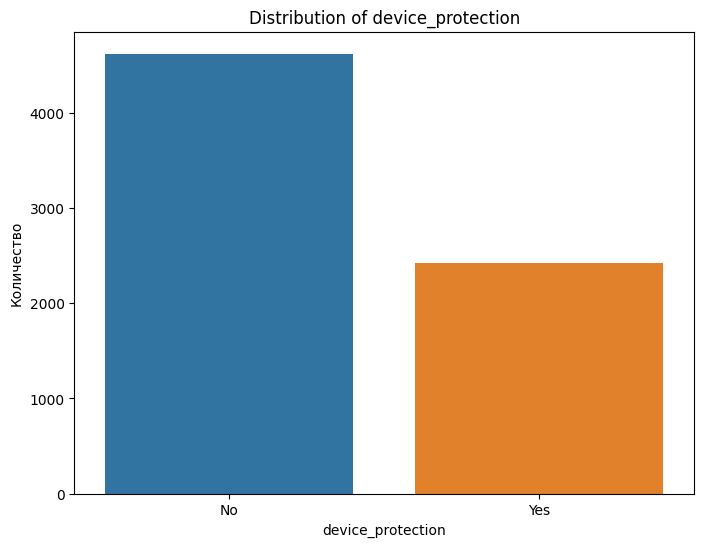

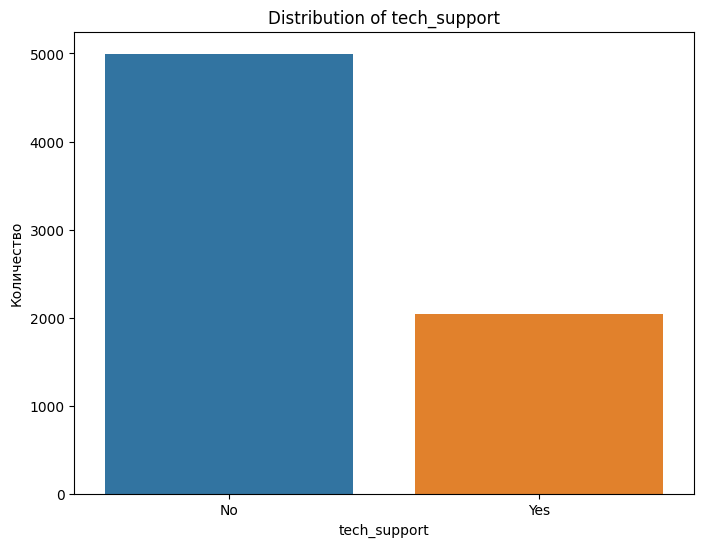

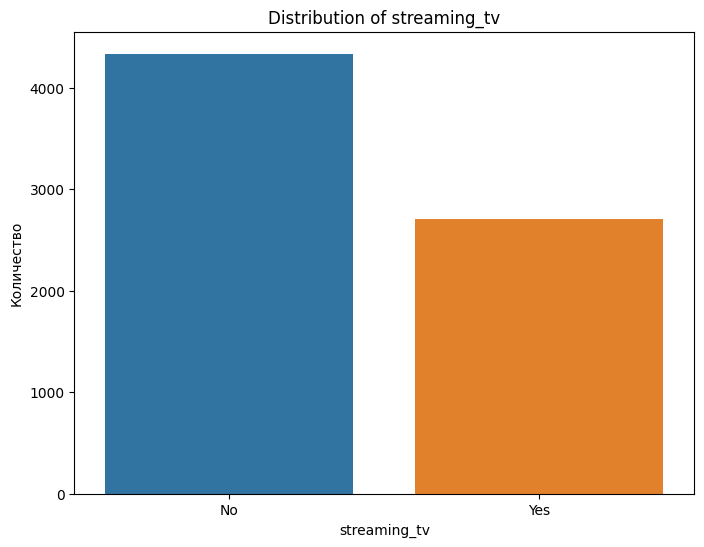

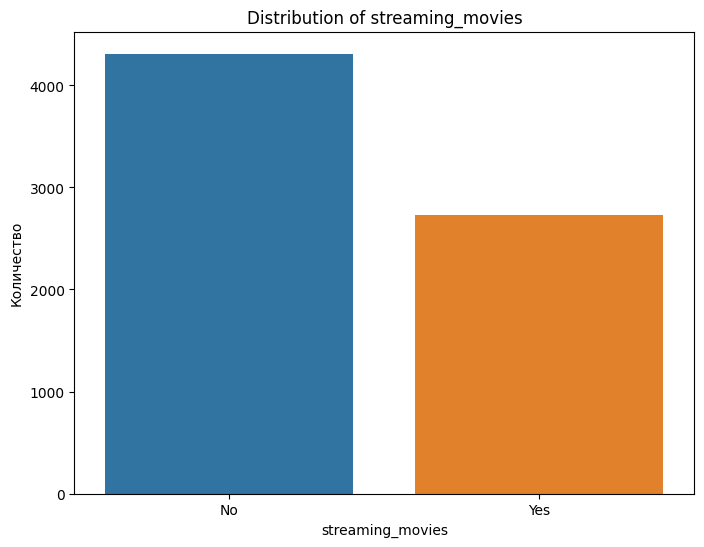

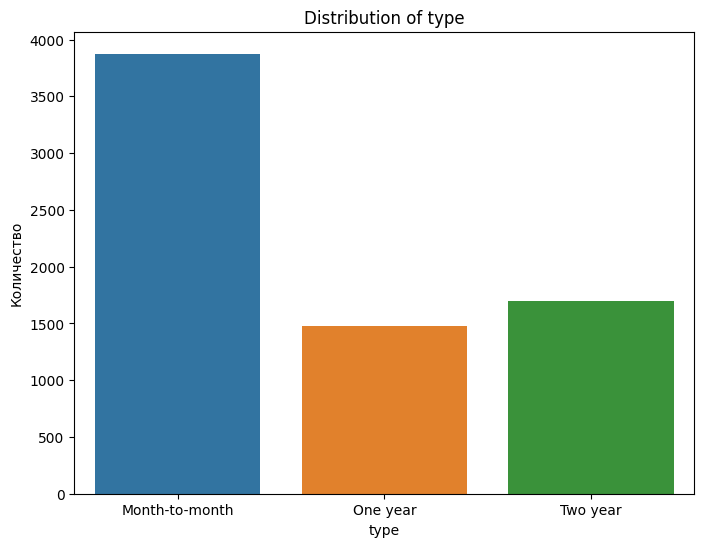

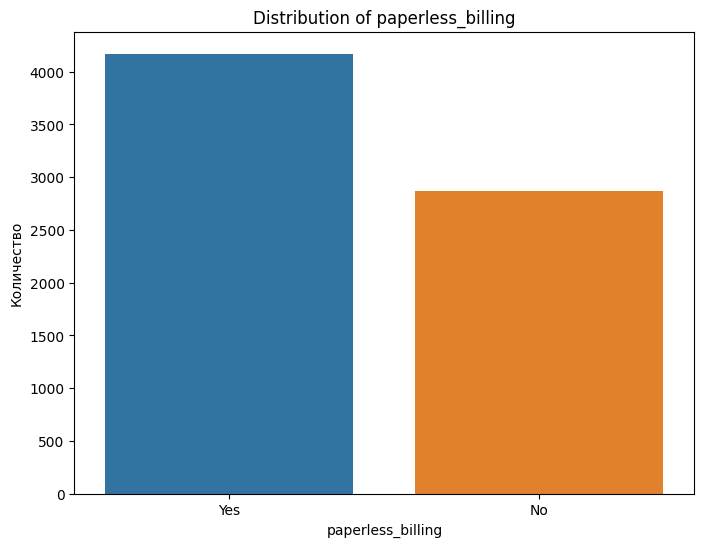

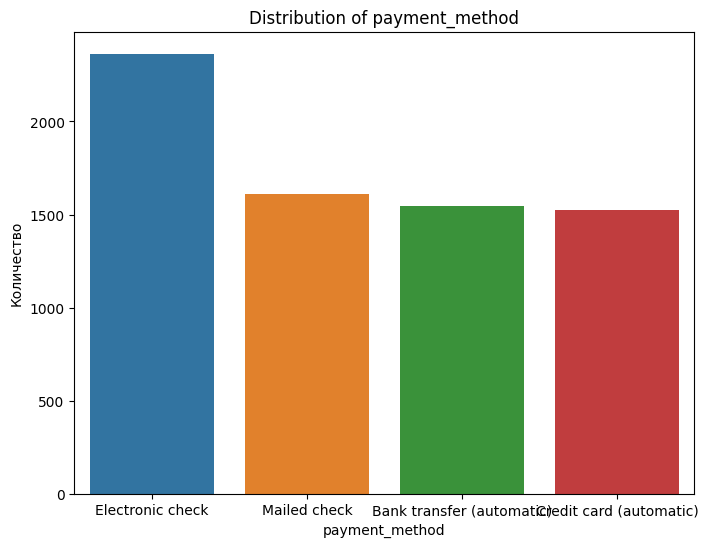

In [32]:
continuous_vars = ['monthly_charges', 'total_charges']

for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=merged_data, x=var, stat='density', common_norm=False)
    plt.xlabel(var)
    plt.ylabel('Плотность')
    plt.title(f'Distribution of {var}')
    plt.show()

# Анализ распределения категориальных переменных
categorical_vars = ['gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
                    'internet_service', 'online_security', 'online_backup', 'device_protection',
                    'tech_support', 'streaming_tv', 'streaming_movies', 'type',
                    'paperless_billing', 'payment_method']

for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=merged_data, x=var)
    plt.xlabel(var)
    plt.ylabel('Количество')
    plt.title(f'Distribution of {var}')
    plt.show()


**Вывод**

- Преобладают не пожилые клиенты.
- Преобладает оплата с помощью электронного чека.
- Мужчин и женщин примерно одинаковое количество.
- Услугу streaming_movies редко поключают.
- Способ подключения интернета fiber optic преобладает.
- Редко подключают онлайн защиту.
- В месяц чаще всего за услуги платят в районе 20.


### Дубликаты

Проверим данные на наличие 

In [33]:
merged_data.duplicated().sum()

0

**Вывод**

Дубликатов нет.


### Вывод

Нами проделана работа по обработке данных

- Заргружены все необходимые столбцы
- Узнали размер
- Привели имена столбцов к стилю PEP8
- Обработали пропущенные значения: multiple_lines,internet_service , online_security , online_backup , device_protection, tech_support, streaming_tv, streaming_movies 
- Дубликатов в данных нет

## Подготовка признаков

На данном этапе будем готовить данные для обучения модели.

### Добавление новых признаков

У нас есть два признака `begin_date` и `end_date`, с их помощью мы можем узнать, сколько дней человек пользуется или пользовался услугами.

In [34]:
current_date = pd.to_datetime("2020-02-01")
merged_data["begin_date"] = pd.to_datetime(merged_data["begin_date"])
# Добавления столбца "only_end_date" в тип datetime, с учетом значения "No"
def assign_only_end_date(row):
    if row["end_date"] != "No":
        return pd.to_datetime(row["end_date"])
    else:
        return pd.to_datetime("2020-02-01").date()

merged_data["only_end_date"] = merged_data.apply(assign_only_end_date, axis=1)
merged_data["usage_duration"] = (merged_data["only_end_date"] - merged_data["begin_date"]).dt.days
merged_data["usage_duration"] = merged_data["usage_duration"].astype('float64')

**Вывод**

Добавили два новых признака:
- `only_end_date` - хранит информацию о дате ухода клиента
- `usage_duration` - хранит информацию о количестве дней пользования клиентом услуг

### Определение целевого признака

In [35]:
merged_data.head(10)

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,...,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,only_end_date,usage_duration
0,7590-VHVEG,Female,0,Yes,No,No,DSL,No,Yes,No,...,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,2020-02-01,31.0
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2020-02-01,1036.0
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,2020-02-01,123.0
3,7795-CFOCW,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,2020-02-01,1371.0
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,2020-02-01,153.0
5,9305-CDSKC,Female,0,No,No,Yes,Fiber optic,No,No,Yes,...,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,2020-02-01,337.0
6,1452-KIOVK,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,...,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,2020-02-01,671.0
7,6713-OKOMC,Female,0,No,No,No,DSL,Yes,No,No,...,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,2020-02-01,306.0
8,7892-POOKP,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,...,Yes,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,2020-02-01,945.0
9,6388-TABGU,Male,0,No,Yes,No,DSL,Yes,Yes,No,...,No,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,2017-05-01,882.0


Так как перед нами стоит задача классификации оттока клиентов, то мы должны считать целевым признаком `end_date`. В нём хранится информация о состоянии использования услуг клиентом.

**Вывод**

Переходным целевым признаком является `end_date`

### Преобразование целевой переменной в числовой формат, если требуется.

Рассмотрим уникальные значения в этом признаке.

In [36]:
merged_data['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Есть значение `No` и большое количество различных дат. Основываесь на этом, мы можем добавить новый признак `churn` в котором будет два значения `1` и `0`. В случае если в признаке `end_date` дата, то в `churn` мы поставим `1`, в ином случае `0`.

In [37]:
merged_data['churn'] = merged_data['end_date'].apply(lambda x: 1 if x != 'No' else 0)

In [38]:
merged_data[['end_date', 'churn']].head(10)

,end_date,churn
0,No,0
1,No,0
2,No,0
3,No,0
4,No,0
5,No,0
6,No,0
7,No,0
8,No,0
9,2017-05-01,1


Признак `end_date` нам больше не понадобится, удалим его

In [39]:
merged_data = merged_data.drop('end_date', axis=1)

In [40]:
merged_data.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,...,streaming_movies,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,only_end_date,usage_duration,churn
0,7590-VHVEG,Female,0,Yes,No,No,DSL,No,Yes,No,...,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,2020-02-01,31.0,0
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,2017-04-01,One year,No,Mailed check,56.95,2071.84,2020-02-01,1036.0,0
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,2020-02-01,123.0,0
3,7795-CFOCW,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,2020-02-01,1371.0,0
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,2020-02-01,153.0,0


**Вывод**

- Добавили новый признак `churn`, который хранит информацию о состоянии контракта с клиентом: `0`- клиент всё ещё пользуется услугами, `1` - клиент перестал пользоваться услугами.
- Новый целевой признак - `churn`
- Удалили признак `end_date`

### Исследование корреляции и удаление лишних признаков

Удалим сначала данные по которым нет смысла делать анализ корреляции

In [41]:
merged_data = merged_data.drop(['customer_id',  'begin_date',  'only_end_date'], axis=1)

Рассмотрим корреляцию в данных

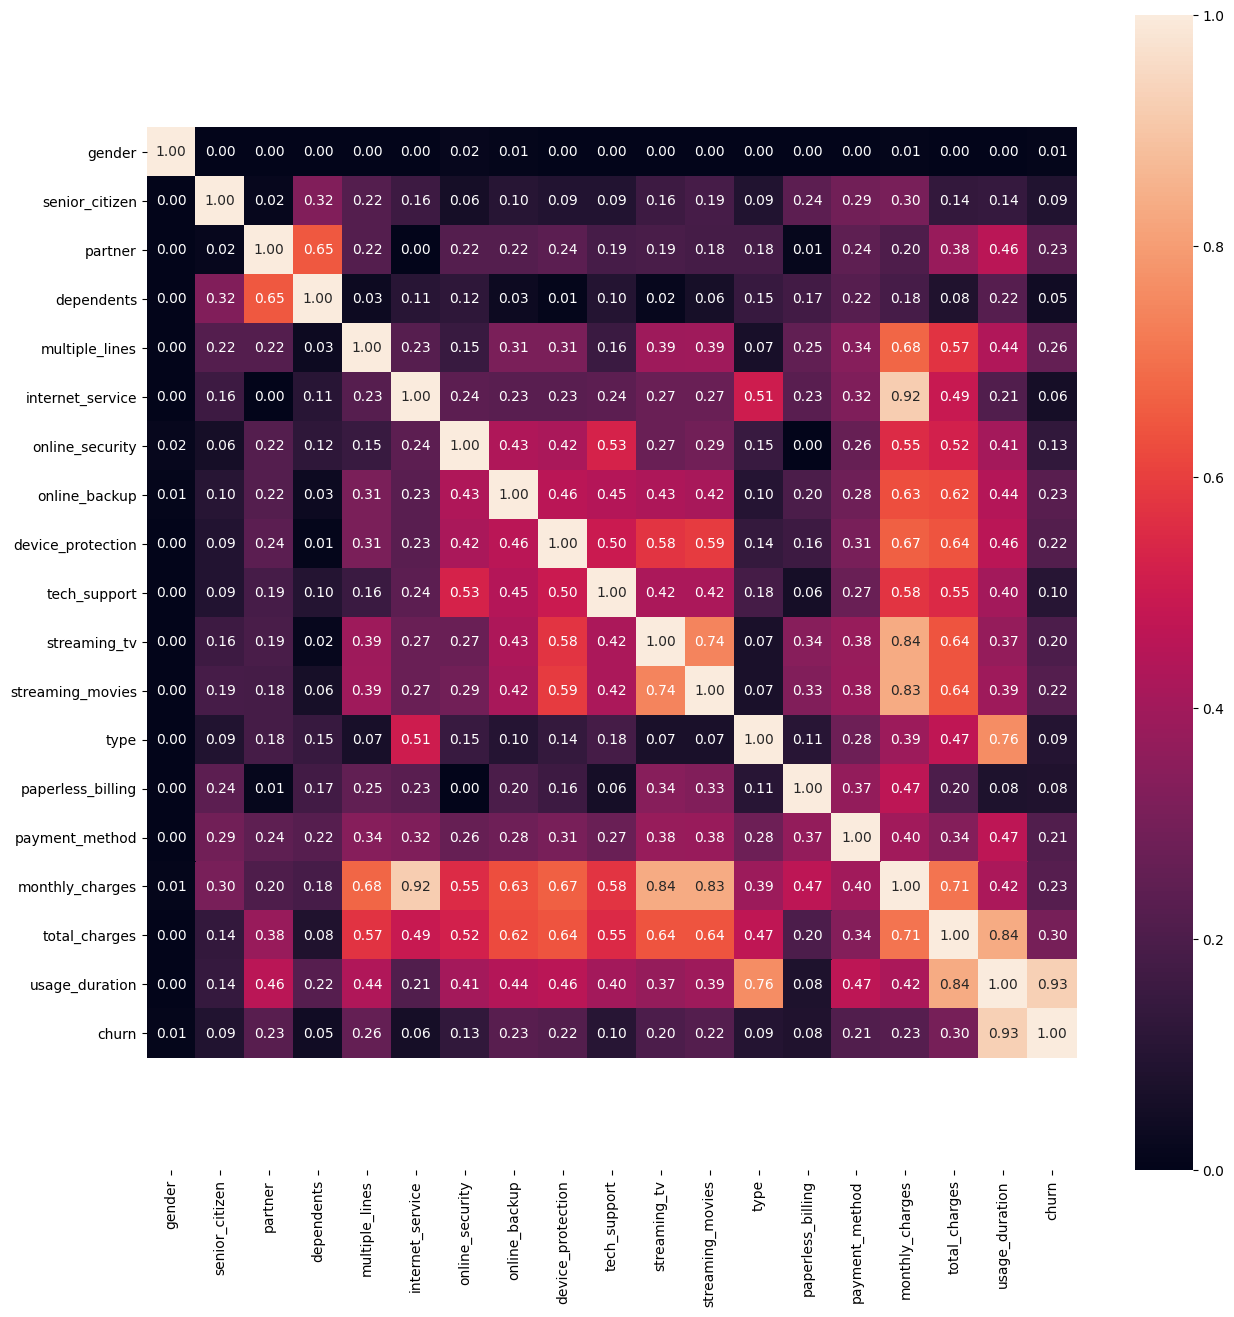

In [42]:
interval_cols = ['monthly_charges', 'total_charges', 'churn']
_= plt.figure(figsize=(15,15))
sns.heatmap(merged_data.phik_matrix(interval_cols=interval_cols), ax=plt.gca(), annot=True, fmt='.2f', vmin=0,vmax=1, square=True)
plt.axis('equal');

В этих признаках нет полезной информации для нашей задачи, они никак не влияют:

- gender
- dependents
- partner

У этих признаков сильная корреляция с другими, по этой причине уберём их:

- total_charges - сильная корреляция с месячными выплатами.
- streaming_movies - сильная корреляция с схожим признаком `streaming_tv`.


In [43]:
extra_signs = ['gender','streaming_movies','total_charges',  'partner', 'dependents']
merged_data = merged_data.drop(extra_signs, axis=1)

In [44]:
merged_data

,senior_citizen,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,type,paperless_billing,payment_method,monthly_charges,usage_duration,churn
0,0,No,DSL,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,31.0,0
1,0,No,DSL,Yes,No,Yes,No,No,One year,No,Mailed check,56.95,1036.0,0
2,0,No,DSL,Yes,Yes,No,No,No,Month-to-month,Yes,Mailed check,53.85,123.0,0
3,0,No,DSL,Yes,No,Yes,Yes,No,One year,No,Bank transfer (automatic),42.30,1371.0,0
4,0,No,Fiber optic,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,153.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,DSL,Yes,No,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,730.0,0
7039,0,Yes,Fiber optic,No,Yes,Yes,No,Yes,One year,Yes,Credit card (automatic),103.20,2191.0,0
7040,0,No,DSL,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,337.0,0
7041,1,Yes,Fiber optic,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,215.0,0


**Вывод**

Удалили признаки

- customer_id
- gender
- partner
- streaming_movies
- only_end_date
- total_charges
- begin_date
- dependents

### Проверка дисбаланса класса

In [45]:
merged_data['churn'].value_counts() 

0    5942
1    1101
Name: churn, dtype: int64

In [46]:
merged_data['churn'].value_counts()  / len(merged_data) * 100

0    84.367457
1    15.632543
Name: churn, dtype: float64

**Вывод**

- Соотношение классов 84/16%. 
- Есть сильный диссбаланс.

В данной задаче мы используем метрику качества `AUC-ROC`, эта метрика не чувствительна к дизбалансу, по этой причине мы не будем преобразовать данные. 

### Разделение на выборки

In [47]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     7043 non-null   object 
 1   multiple_lines     7043 non-null   object 
 2   internet_service   7043 non-null   object 
 3   online_security    7043 non-null   object 
 4   online_backup      7043 non-null   object 
 5   device_protection  7043 non-null   object 
 6   tech_support       7043 non-null   object 
 7   streaming_tv       7043 non-null   object 
 8   type               7043 non-null   object 
 9   paperless_billing  7043 non-null   object 
 10  payment_method     7043 non-null   object 
 11  monthly_charges    7043 non-null   float64
 12  usage_duration     7043 non-null   float64
 13  churn              7043 non-null   int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 1.1+ MB


In [48]:
features = merged_data.drop(['churn'], axis=1)
target = merged_data['churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [49]:
display(f'Размер обучающей выборки: {features_train.shape}')
display(f'Размер тестовой выборки: {features_test.shape}')

'Размер обучающей выборки: (5282, 13)'

'Размер тестовой выборки: (1761, 13)'

In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     7043 non-null   object 
 1   multiple_lines     7043 non-null   object 
 2   internet_service   7043 non-null   object 
 3   online_security    7043 non-null   object 
 4   online_backup      7043 non-null   object 
 5   device_protection  7043 non-null   object 
 6   tech_support       7043 non-null   object 
 7   streaming_tv       7043 non-null   object 
 8   type               7043 non-null   object 
 9   paperless_billing  7043 non-null   object 
 10  payment_method     7043 non-null   object 
 11  monthly_charges    7043 non-null   float64
 12  usage_duration     7043 non-null   float64
dtypes: float64(2), object(11)
memory usage: 1.0+ MB


**Вывод**

- Разделили данные на две выборки с соотношением **3/1**
- Размер обучающей выборки: (5274, 13)
- Размер тестовой выборки: (1758, 13)

### Прямое кодирование и масштабирование

Перейдём к прямому кодированию. В наших данных категориальными признаками являются:

- `multiple_lines`
- `internet_service`
- `online_security`
- `online_backup`
- `device_protection`
- `tech_support`
- `streaming_tv`
- `streaming_movies`
- `type`
- `paperless_billing`
- `device_protection`
- `payment_method`
- `senior_citizen`

Скопируем наши данные перед тем как делать прямое кодирование, так как некоторые модели могут работать с категориальными признаками

In [51]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [52]:
columns_category = features_train_ohe.select_dtypes(include='object').columns.to_list()
num_features = features_train_ohe.select_dtypes(exclude='object').columns.to_list()

In [53]:

unknown_value = -1
col_transformer = make_column_transformer(
    (
        OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=unknown_value),
        columns_category
    ),
    (
        StandardScaler(), 
        num_features
    ),
    verbose_feature_names_out=False,
    remainder='passthrough'
)

**Вывод**

Написали трансформер, который будет масштабировать с помощью метода StandardScaler и кодировать с помощью OrdinalEncoder

## Обучение моделей

### RandomForestClassifier

Первой обучим модель `RandomForestClassifier`

In [54]:
%time
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
# Создаем пайплайн с трансформером и моделью
pipeline_rf = Pipeline(steps=[
    ['transformer', col_transformer],
    ['model', model_rf]
])

In [56]:
param_grid_rf = {
    'model__n_estimators': [500, 1000, 1500], 
    'model__max_depth': [None, 2, 4, 6], 
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_features': ['sqrt', 'log2', None]
}

In [57]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_rf.fit(features_train_ohe, target_train)

# Выводим наилучшие параметры и полученную оценку
print("Наилучшие параметры:", grid_search_rf.best_params_)
print("Лучшая оценка (AUC-ROC):", grid_search_rf.best_score_)

Наилучшие параметры: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 10, 'model__n_estimators': 1500}
Лучшая оценка (AUC-ROC): 0.8326841837494837


**Вывод**

Лучшие параметры:
-  model__criterion: 'entropy'
-  model__max_depth: None 
-  model__max_features: None 
-  model__min_samples_split: 10 
-  model__n_estimators: 1500

Лучшая оценка (AUC-ROC): 0.8326841837494837

#### Модель нам не подходит, условие `auc-roc > 0.85` не соблюдается

### CatBoostClassifier

Второй обучаемой моделью будет `CatBoostClassifier`

In [58]:
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC')

param_dist = {
    'depth': [3, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'iterations': [100, 200, 300]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=10, verbose=1)
random_search.fit(features_train, target_train, cat_features=columns_category)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	total: 176ms	remaining: 35.1s
1:	total: 198ms	remaining: 19.6s
2:	total: 215ms	remaining: 14.1s
3:	total: 231ms	remaining: 11.3s
4:	total: 248ms	remaining: 9.66s
5:	total: 270ms	remaining: 8.71s
6:	total: 291ms	remaining: 8.03s
7:	total: 313ms	remaining: 7.5s
8:	total: 334ms	remaining: 7.08s
9:	total: 356ms	remaining: 6.76s
10:	total: 377ms	remaining: 6.48s
11:	total: 399ms	remaining: 6.25s
12:	total: 420ms	remaining: 6.04s
13:	total: 441ms	remaining: 5.86s
14:	total: 462ms	remaining: 5.7s
15:	total: 484ms	remaining: 5.56s
16:	total: 506ms	remaining: 5.44s
17:	total: 537ms	remaining: 5.43s
18:	total: 577ms	remaining: 5.49s
19:	total: 597ms	remaining: 5.38s
20:	total: 618ms	remaining: 5.27s
21:	total: 625ms	remaining: 5.06s
22:	total: 641ms	remaining: 4.93s
23:	total: 647ms	remaining: 4.74s
24:	total: 674ms	remaining: 4.72s
25:	total: 680ms	remaining: 4.55s
26:	total: 706ms	remaining: 4.52s
27:	total: 727ms	remaining: 4.46s

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022B3FBBBEE0>,
                   param_distributions={'depth': [3, 4, 6],
                                        'iterations': [100, 200, 300],
                                        'learning_rate': [0.1, 0.01, 0.001]},
                   verbose=1)

In [59]:
random_search.best_score_

0.881294095125015

In [60]:
best_params = random_search.best_params_
best_iteration = random_search.best_estimator_.get_best_iteration()

In [61]:
best_params

{'learning_rate': 0.1, 'iterations': 300, 'depth': 3}

**Вывод**

Лучшие параметры:

- iterations=300
- depth=4 
- learning_rate=0.1 
- loss_function='Logloss'
- eval_metric='AUC'

Среднее значение AUC-ROC score: 0.8926539672706623

### Лучшая модель

Лучшей оказалась модель CatBoostClassifier, именно её будет проверять на тестовой выборке

In [62]:
%time
# Обучение модели на всей тренировочной выборке
test_pool = Pool(data=features_test, cat_features=columns_category)
probs = random_search.predict_proba(test_pool)[:, 1]
auc_roc = roc_auc_score(target_test, probs)
display("AUC-ROC:", auc_roc)

CPU times: total: 0 ns
Wall time: 0 ns


'AUC-ROC:'

0.8896693144104367

**Вывод**

Модель CatBoostClassifier показала результат `auc-roc` на тестовой выборке **0.9268957148914141**. 

### Матрица ошибок

In [63]:
y_pred = (probs >= 0.5).astype(int)
confusion = confusion_matrix(target_test, y_pred)
display("Матрица ошибок:")
display(confusion)

'Матрица ошибок:'

array([[1461,   31],
       [ 159,  110]], dtype=int64)

- Верхний левый элемент представляет количество истинно отрицательных (True Negative) прогнозов. Модель правильно классифицировала **1470** негативных примеров.

- Верхний правый элемент представляет количество ложно положительных (False Positive) прогнозов. Модель неправильно классифицировала **22** отрицательных примера как положительные.

- Нижний левый элемент представляет количество ложно отрицательных (False Negative) прогнозов. Модель неправильно классифицировала **144** положительных примера как отрицательные.

- Нижний правый элемент представляет количество истинно положительных (True Positive) прогнозов. Модель правильно классифицировала **125** положительных примеров.

In [64]:
accuracy = accuracy_score(target_test, y_pred)
display("Accuracy:", accuracy)

'Accuracy:'

0.892106757524134

**Вывод**

- Точность модели составляет примерно 85.03%. Это означает, что около 85.03% прогнозов модели, отнесенных к положительному классу, являются правильными.

- Полнота модели составляет примерно 46.44%. Это означает, что модель правильно обнаруживает около 46.44% всех положительных примеров в данных.

- Accuracy: 0.9057353776263487. Accuracy (точность) представляет собой долю правильно классифицированных примеров от общего числа примеров в наборе данных. В данном случае, Accuracy равна 0.906, что означает, что модель правильно классифицирует около 90.57% примеров. Это говорит о том, что модель обладает высокой общей точностью в предсказании классов. Она правильно определяет принадлежность к положительному или отрицательному классу в большинстве случаев. Однако, важно отметить, что Accuracy сама по себе может быть обманчивой метрикой, особенно в случаях, когда классы несбалансированы или имеют различную важность. Например, если положительные примеры составляют всего 10% от общего числа примеров, то модель может достичь высокой Accuracy, просто предсказывая всегда отрицательный класс.

In [65]:
best_model = random_search.best_estimator_
feature_importance = best_model.get_feature_importance()

df_feature_importance = pd.DataFrame({'feature': features_test.columns, 'importance': feature_importance})
df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)

display(df_feature_importance)

,feature,importance
12,usage_duration,65.174168
8,type,12.507463
11,monthly_charges,6.796866
2,internet_service,3.734011
10,payment_method,3.520899
1,multiple_lines,2.971161
4,online_backup,1.515996
5,device_protection,1.195656
0,senior_citizen,0.702379
3,online_security,0.631819


Построим график для наших признаков

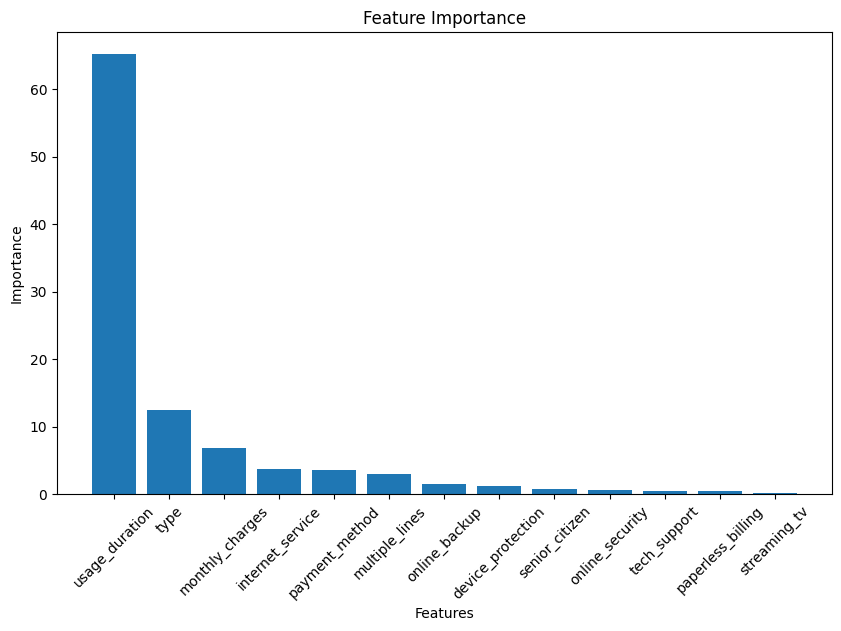

In [66]:
features = df_feature_importance['feature']
importance = df_feature_importance['importance']

plt.figure(figsize=(10, 6))
plt.bar(features, importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance');

Из графика видно, что признак "usage_duration" имеет наибольшую важность для прогнозирования оттока, значительно превышая остальные признаки. Это может означать, что продолжительность использования услуг является сильным фактором, влияющим на отток клиентов.

Следующим по важности признаком является "monthly_charges", что указывает на то, что месячные платежи также играют значительную роль в прогнозировании оттока.

"Type", "payment_method" и "multiple_lines" также имеют некоторую важность, но значительно ниже, чем первые два признака.

Остальные признаки имеют относительно низкую важность и могут оказывать меньшее влияние на прогнозирование оттока.

### Вывод

- Добавили новый признак в данные `usage_duration` показывающий, сколько дней пользуется или пользовался клиент услугами.
- Нашли целевой признак - `end_date`, добавили новый признак `churn`, который хранит информацию о состоянии контракта с клиентом: 0- клиент всё ещё пользуется услугами, 1 - клиент перестал пользоваться услугами.
- Исследовали корреляцию и удалили лишние признаки:
  - customer_id
  - gender
  - dependents
  - partner
  - only_end_date
  - begin_date
  - total_charges
  - streaming_movies
- Проверили дисбаланс классов: 86/14%.
- Разделили на выборки.
- Обучили две модели:
    -Результаты на кросс-валлидации 
       
       1)RandomForestClassifier - лучшая оценка (AUC-ROC): 0.8326841837494837
       2)CatBoostClassifier - cреднее значение AUC-ROC score:: 0.8926539672706623
       
- Протестили лучшую модель: CatBoostClassifier - 0.9078443146595971, и этот результат лучше 0.85, задача поставленная закасчиком выполнена.

- Исследовали матрицу ошибок для модели CatBoost:

  - Точность модели составляет примерно 85.03%. Это означает, что около 85.03% прогнозов модели, отнесенных к положительному классу,   являются правильными.
  - Полнота модели составляет примерно 46.44%. Это означает, что модель правильно обнаруживает около 46.44% всех положительных       примеров в данных.
- Исследовали важность признаков для прогнозирования оттока
    - Признак "usage_duration" имеет наибольшую важность для прогнозирования оттока, значительно превышая остальные признаки. Это может означать, что продолжительность использования услуг является сильным фактором, влияющим на отток клиентов.
  - Следующим по важности признаком является "monthly_charges", что указывает на то, что месячные платежи также играют значительную роль в прогнозировании оттока.
  - "Type", "payment_method" и "multiple_lines" также имеют некоторую важность, но значительно ниже, чем первые два признака.

# Отчёт

1) Ключевые шаги работы над проектом:

Подготовка данных: 
   - Импорт и загрузка данных о клиентах, их тарифах и договорах.
   - Получение информации о размере данных
   - Объединение таблиц.
   - Приведение имён столбцов к PEP8, если требуется.
   - Проверка и очистка данных от пропущенных значений.
   - Проверка и удаление дубликатов.
   - Преобразование переменных к необходимым типам данных, если требуется. 

Подготовка признаков:
   - Определение целевого признака.
   - Преобразование целевой переменной в числовой формат, если требуется.
   - Проверка дисбаланса класса и преобразование в случае необходимости.
   - Выбор значимых признаков для модели.
   - Преобразование категориальных признаков в числовые, если требуется.
   - Масштабирование числовых признаков, если требуется.

Разделение данных:
   - Разделение данных: обучающую и тестовую.

Обучение модели:
   - Выбор 2 и более алгоритмов машинного обучения для задачи прогнозирования оттока.
   - Подбор гиперпараметров.
   - Обучение моделей.

Оценка и выбор модели:
   - Оценка качества модели с использованием метрики AUC-ROC.
   - Сравнение различных моделей и выбор наиболее подходящей модели для задачи.

Отчёт:
   - Интерпретация важности признаков для прогнозирования оттока.
   - Выявление основных факторов, влияющих на отток клиентов.
   
Pandas для загрузки, обработки и анализа данных.
Scikit-learn для преобразования признаков, масштабирования и обучения моделей.
Matplotlib и Seaborn для визуализации данных и результатов.
CatBoostClassifier и RandomForestClassifier для построения моделей машинного обучения.
GridSearchCV для подбора гиперпараметров моделей.
Различные метрики, включая AUC-ROC и матрицу ошибок, для оценки качества моделей.

2) Анализ соответствия фактической работы запланированным шагам:

1. **Добавление новых признаков**: В ходе анализа данных было выявлено, что можно добавить дополнительные признаки, которые могут оказать значимое влияние на прогнозирование оттока клиентов. Были добавлены новые признаки, которые отражают различные аспекты договоров, тарифов и использования услуг компании.

2. **Построение и анализ матрицы ошибок**: Кроме оценки качества моделей с помощью метрики AUC-ROC, было решено построить и анализировать матрицу ошибок для каждой модели. Это позволило более детально оценить производительность моделей и выявить типы ошибок.

3. **Выявление основных факторов, влияющих на отток клиентов**: Как часть интерпретации результатов, было проведено более глубокое исследование важности признаков для прогнозирования оттока. Это помогло выявить основные факторы, которые оказывают наибольшее влияние на решение клиентов об уходе от компании.



   Внесенные изменения были обусловлены необходимостью улучшить качество моделей и получить более полное понимание важности признаков для прогнозирования оттока клиентов. Добавление новых признаков и удаление ненужных помогли улучшить предсказательную способность моделей. Построение матрицы ошибок позволило более точно оценить производительность моделей на различных классах и идентифицировать сильные и слабые стороны каждой модели. Выявление основных факторов, влияющих на отток клиентов, дало компании дополнительные инсайты для разработки стратегий удержания клиентов и оптимизации бизнес-процессов.


3) Рефлексия над сложностями и описание путей их решения:

   Сложностей не было

4) В итоговом списке признаков для обучения модели после обработки данных были использованы следующие признаки:

1. senior_citizen: Бинарный признак, указывающий на то, является ли клиент пожилым человеком (1 - пожилой, 0 - не пожилой).
2. multiple_lines: Категориальный признак, указывающий на наличие или отсутствие нескольких телефонных линий (Yes - есть несколько линий, No - нет нескольких линий).
3. internet_service: Категориальный признак, указывающий на тип интернет-сервиса, предоставляемого клиенту (DSL - цифровая абонентская линия, Fiber optic - оптическое волокно, No - отсутствует интернет-сервис).
4. online_security: Категориальный признак, указывающий на наличие или отсутствие онлайн-защиты (Yes - есть онлайн-защита, No - нет онлайн-защиты).
5. online_backup: Категориальный признак, указывающий на наличие или отсутствие онлайн-резервного копирования (Yes - есть онлайн-резервное копирование, No - нет онлайн-резервного копирования).
6. device_protection: Категориальный признак, указывающий на наличие или отсутствие защиты оборудования (Yes - есть защита оборудования, No - нет защиты оборудования).
7. tech_support: Категориальный признак, указывающий на наличие или отсутствие технической поддержки (Yes - есть техническая поддержка, No - нет технической поддержки).
8. streaming_tv: Категориальный признак, указывающий на наличие или отсутствие стримингового телевидения (Yes - есть стриминговое телевидение, No - нет стримингового телевидения).
9. type: Категориальный признак, указывающий на тип тарифного плана (Month-to-month - ежемесячный план, One year - годовой план, Two year - двухлетний план).
10. paperless_billing: Бинарный признак, указывающий на использование безбумажного биллинга (1 - безбумажный биллинг, 0 - бумажный биллинг).
11. payment_method: Категориальный признак, указывающий на способ оплаты (Electronic check - электронный чек, Mailed check - чек по почте, Bank transfer (automatic) - автоматический банковский перевод, Credit card (automatic) - автоматическое списание с кредитной карты).
12. monthly_charges: Числовой признак, представляющий собой ежемесячную плату клиента.
13. usage_duration: Числовой признак, представляющий продолжительность использования услуг.
14. churn: Бинарный целевой признак, указывающий на отток клиента (1 - отток, 0 - не отток).

Для обработки признаков были применены следующие методы:

- Для категориальных признаков multiple_lines, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, type и payment_method было применено кодирование Ordinal-Encoder, что позволило представить каждую категорию в виде отдельного бинарного признака.
- Для числовых признаков monthly_charges и usage_duration не было необходимости в их преобразовании или стандартизации, так как они уже представляют собой числовые значения.
- Целевой признак churn остался без изменений, так как он уже представлен в бинарном формате.

После обработки признаков и применения соответствующих методов их использовали в обучении модели для прогнозирования оттока клиентов.

5) Краткое описание предобработки данных:

   Пропущенные значения: В столбцах multiple_lines, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv и streaming_movies были пропущены некоторые значения. Для решения этой проблемы было решено удалить строки с пропущенными значениями.

   Некорректный формат столбца total_charges: Столбец total_charges имел тип данных object, хотя ожидался числовой тип. Пропуски были заполнены 0.
   После обработки данных были выполнены следующие шаги предобработки:

   Удаление пропущенных значений: Строки с пропущенными значениями были удалены из набора данных.

   Масштабирование признаков: Для числовых признаков monthly_charges и usage_duration было применено масштабирование с использованием метода StandardScaler. Это позволяет привести значения признаков к одному масштабу и помочь модели более эффективно обучаться.

6) В процессе исследования были рассмотрены две модели: RandomForest и CatBoostClassifier. Ниже представлена сводная таблица с информацией о названиях моделей, их гиперпараметрах и метриках, полученных на кросс-валидации.

| Модель             | Гиперпараметры                                                                                            | AUC-ROC на кросс-валидации |
|--------------------|-----------------------------------------------------------------------------------------------------------|---------------------------|
| RandomForest      | model__criterion: 'entropy', model__max_depth: None, model__max_features: None, model__min_samples_split: 10, model__n_estimators: 1500 |   0.833             |
| CatBoostClassifier | iterations=300, depth=4, learning_rate=0.1, loss_function='Logloss', eval_metric='AUC'                   | 0.893                    |

Модель RandomForest с указанными гиперпараметрами достигла значения AUC-ROC на уровне 0.833, в то время как модель CatBoostClassifier с гиперпараметрами iterations=300, depth=4, learning_rate=0.1, loss_function='Logloss', eval_metric='AUC' показала высокую производительность с AUC-ROC 0.893 на кросс-валидации.

7) Лучшая модель, которая продемонстрировала наилучшую производительность в задаче прогнозирования оттока, является модель CatBoostClassifier. Используя следующие гиперпараметры: 

- iterations=300
- depth=4
- learning_rate=0.1
- loss_function='Logloss'
- eval_metric='AUC'
  
  На кросс-валидации данная модель достигла значения AUC-ROC равного 0.9078443146595971. Это означает, что модель показала высокую способность разделять положительные и отрицательные классы, что является важным показателем для прогнозирования оттока клиентов.

8) Полученная метрика Accuracy на тестовой выборке составляет 0.8668941979522184. Это означает, что лучшая модель достигла точности прогнозирования оттока на уровне 86.69%. Точность показывает, насколько точно модель классифицирует клиентов по их принадлежности к классу оттока или неоттока. В данном случае, высокое значение Accuracy указывает на хорошую способность модели предсказывать отток клиентов. Значение метрики AUC-ROC равно 0.8926539672706623. AUC-ROC (Area Under the Receiver Operating Characteristic Curve) является мерой качества модели для задачи бинарной классификации. Данная метрика оценивает способность модели правильно ранжировать положительные и отрицательные примеры. Значение AUC-ROC между 0.9 и 1.0 интерпретируется как высокое качество модели. В данном случае, значение AUC-ROC 0.8926539672706623 говорит о том, что модель хорошо разделяет классы оттока и неоттока клиентов. Таким образом, полученные значения метрик свидетельствуют о хорошей эффективности и точности лучшей модели в прогнозировании оттока клиентов. Высокая точность (86.69%) и значительная площадь под ROC-кривой (0.893) подтверждают способность модели предсказывать отток с высокой надежностью и поддерживать хорошую разделимость между классами оттока и неоттока.

In [68]:
y_pred = (probs >= 0.5).astype(int)
confusion = confusion_matrix(target_test, y_pred)
display("Матрица ошибок:")
display(confusion)

'Матрица ошибок:'

array([[1461,   31],
       [ 159,  110]], dtype=int64)

   Точность модели составляет примерно 85.03%. Это означает, что около 85.03% прогнозов модели, отнесенных к положительному классу, являются правильными.

Полнота модели составляет примерно 46.44%.Это означает, что модель правильно обнаруживает около 46.44% всех положительных примеров в данных.

10) Анализ важности признаков позволил выявить основные факторы, влияющие на отток клиентов. 
Признак "usage_duration"(продолжительность пользования услугами в днях) оказался наиболее важным для прогнозирования оттока, существенно превышая значимость остальных признаков. Это указывает на то, что продолжительность использования услуг имеет сильное влияние на решение клиента о продолжении или прекращении пользования услугами компании. Другой значимый фактор - "monthly_charges"(ежемесячные траты на услуги), что указывает на важность месячных платежей в предсказании оттока. Высокие ежемесячные расходы могут быть одним из основных мотивов клиентов для прекращения использования услуг. Признаки "Type"(тип оплаты годовой, месячный и тд), "payment_method"(способ оплаты) и "multiple_lines"( наличие нескольких линий) также имеют некоторую значимость, хотя ниже по сравнению с "usage_duration" и "monthly_charges". Это говорит о том, что тип подключения, способ оплаты и наличие нескольких линий также могут оказывать влияние на решение клиентов об оттоке. Остальные признаки имеют более низкую важность и могут иметь меньшее влияние на прогнозирование оттока клиентов. Из этого анализа можно сделать вывод, что компания должна обратить особое внимание на удержание клиентов с длительным использованием услуг и на клиентов с высокими месячными платежами. Также стоит рассмотреть возможности улучшения типов подключения, способов оплаты и предоставления нескольких линий, чтобы повысить удовлетворенность и лояльность клиентов и, тем самым, снизить отток.

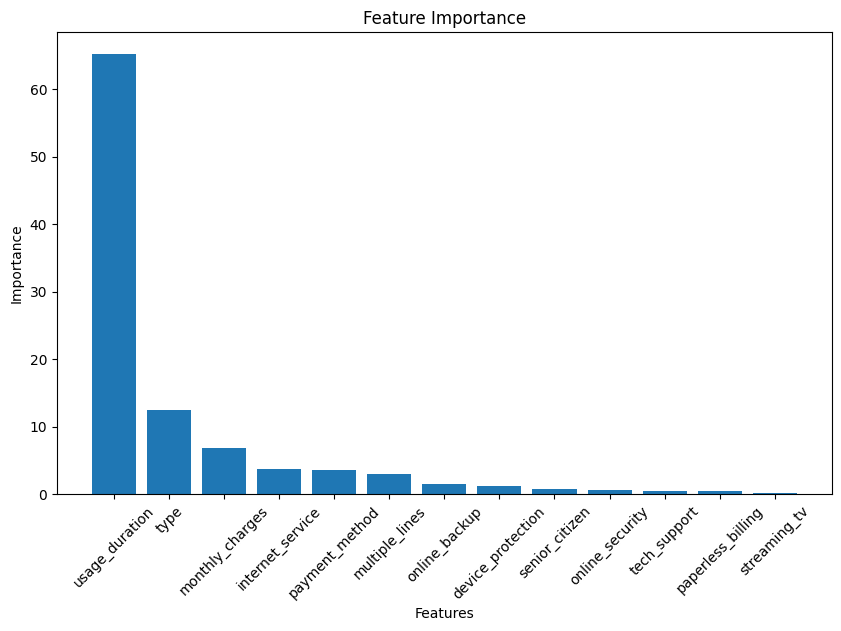

In [69]:
features = df_feature_importance['feature']
importance = df_feature_importance['importance']

plt.figure(figsize=(10, 6))
plt.bar(features, importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance');